In [ ]:
!pip install tensorflow
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import faiss  # Install with: pip install faiss-cpu (or faiss-gpu for GPU support)
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.random_projection import SparseRandomProjection

In [ ]:
# Load MNIST data using TensorFlow/Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Load MNIST fashion data using tf keras
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
len(x_test)

10000

In [ ]:
# Preprocess: Flatten and scale
x_train = x_train.reshape(-1, 784).astype(np.float32)  # Flatten 28x28 to 784
x_test = x_test.reshape(-1, 784).astype(np.float32)
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

In [ ]:
# Normalize data for cosine similarity
X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_train_normalized = X_train_normalized.astype(np.float32)  # Faiss requires float32

In [ ]:
epsilon = 1e-4  # Tolerance
t_max = 100   # max_iterations
learning_rate = 0.05  # For gradient descent
w_0 = np.random.randn(784, 10)  # initial weights:: Example: Weights for a simple linear model

In [ ]:
# Define multiple lambda values to test
lambda_values = [0.1, 0.5, 1.0]  # Different compression factors
history_dict = {}  # To store training histories
test_accuracies = {}  # To store test accuracies

In [ ]:
## Tensorflow approach (Uses GPU and significantly speeding up the process)
def compute_gradient_tf(X, y, weights):
    """Computes the gradient of the loss function using TensorFlow."""
    # Convert weights to a TensorFlow variable
    weights_tf = tf.Variable(weights)
    with tf.GradientTape() as tape:
        logits = X @ weights_tf  # Use the TensorFlow variable here
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.one_hot(y, depth=10), logits=logits
        ))
    gradient = tape.gradient(loss, weights_tf)  # Calculate gradient with respect to the TensorFlow variable
    return gradient.numpy()

In [ ]:
# Hashing(dimensionality reduction) and clustering

def lsh_clustering(X, n_clusters, n_bits=32):

    # -------------------------------------------------------------------------------------------------------------------------------
    # Apply random projection (LSH)
    lsh = SparseRandomProjection(n_components=n_bits, random_state=42)
    X_hashed = lsh.fit_transform(X)

    # Normalize hashed vectors
    X_hashed = X_hashed / np.linalg.norm(X_hashed, axis=1, keepdims=True)
    # ----------------------------------------------------------------------------------------------------------------------------

    # Use Faiss with cosine similarity on hashed data
    index = faiss.IndexFlatIP(n_bits)
    X_hashed = X_hashed.astype(np.float32)
    kmeans = faiss.Clustering(n_bits, n_clusters)
    kmeans.verbose = True
    kmeans.niter = 10  # Reduced iterations for speed
    kmeans.train(X_hashed, index)

    centroids_hashed = faiss.vector_to_array(kmeans.centroids).reshape(n_clusters, n_bits)
    D, I = index.search(X_hashed, 1)
    clusters = I.flatten()

    # Compute actual centroids in original space
    centroids = np.zeros((n_clusters, X.shape[1]), dtype=np.float32)
    for i in range(n_clusters):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)

    return centroids, clusters

In [ ]:
def faiss_clustering(X_train_normalized, target_clusters):

    # Faiss clustering
    index = faiss.IndexFlatIP(784)
    kmeans = faiss.Clustering(784, target_clusters)
    kmeans.verbose = True
    kmeans.niter = 20
    kmeans.seed = 42
    kmeans.train(X_train_normalized, index)

    # Get cluster assignments and centroids
    centroids_normalized = faiss.vector_to_array(kmeans.centroids).reshape(target_clusters, 784)
    D, I = index.search(X_train_normalized, 1)
    clusters = I.flatten()
    centroids = centroids_normalized * np.linalg.norm(X_train, axis=1).mean()

    return centroids, clusters

In [ ]:
# Run for each lambda value
for lambda_val in lambda_values:
    start_time = time.time()
    print(f"\nProcessing lambda = {lambda_val}")

    # Set target clusters based on lambda
    target_clusters = int(len(X_train) * lambda_val)

    # LSH clustering
    # centroids, clusters = lsh_clustering(X_train_normalized, target_clusters)

    # Faiss Clustering
    centroids, clusters = faiss_clustering(X_train_normalized, target_clusters)

    # Extract representative labels
    h_k = np.zeros(len(centroids), dtype=np.uint8)
    for i in range(len(centroids)):
        cluster_labels = y_train[clusters == i]
        if len(cluster_labels) > 0:
            h_k[i] = np.bincount(cluster_labels).argmax()

    # Gradient descent optimization
    weights = w_0.copy()
    for iteration in range(t_max):
        previous_centroids = centroids.copy()
        for cluster_idx in range(len(centroids)):
            cluster_points = X_train[clusters == cluster_idx]
            cluster_labels = y_train[clusters == cluster_idx]
            original_gradient = compute_gradient_tf(cluster_points, cluster_labels, weights)
            compressed_gradient = compute_gradient_tf(centroids[cluster_idx].reshape(1, -1),
                                                    np.array([h_k[cluster_idx]]), weights)
            centroids[cluster_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)

        change = np.max(np.linalg.norm(centroids - previous_centroids, axis=1))
        if change <= epsilon:
            break

    # Assign compressed data
    compressed_X = centroids
    compressed_y = h_k

    # Reshape compressed_X to 2D image format for CNN (28, 28, 1)
    compressed_X_2d = compressed_X.reshape(-1, 28, 28, 1)  # Shape: (target_clusters, 28, 28, 1)
    X_test_2d = X_test.reshape(-1, 28, 28, 1)             # Shape: (10000, 28, 28, 1)


    # model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model on compressed data
    history = model.fit(compressed_X_2d, compressed_y,
                        epochs=10,
                        verbose=1)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test_2d, y_test, verbose=0)

    # Store results
    history_dict[lambda_val] = history.history
    test_accuracies[lambda_val] = test_acc

    end_time = time.time()
    print(f"Lambda {lambda_val} - Time taken: {end_time - start_time:.2f}s, Test accuracy: {test_acc:.4f}")


Processing lambda = 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7178 - loss: 0.8781
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9319 - loss: 0.2006
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9570 - loss: 0.1358
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9635 - loss: 0.1169
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9735 - loss: 0.0762
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9811 - loss: 0.0599
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9789 - loss: 0.0536
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9916 - loss: 0.0292
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9935 - loss: 0.0213
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9933 - loss: 0.0191
Lambda 0.1 - Time taken: 349.29s, Test accuracy: 0.9691

Processing lambda = 0.5
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms

In [ ]:
# # Run for each lambda value
# for lambda_val in lambda_values:
#     start_time = time.time()
#     print(f"\nProcessing lambda = {lambda_val}")

#     # Set target clusters based on lambda
#     target_clusters = int(len(X_train) * lambda_val)

#     # LSH clustering
#     centroids, clusters = lsh_clustering(X_train_normalized, target_clusters)

#     # Faiss Clustering
#     # centroids, clusters = faiss_clustering(X_train_normalized, target_clusters)

#     # Extract representative labels
#     h_k = np.zeros(len(centroids), dtype=np.uint8)
#     for i in range(len(centroids)):
#         cluster_labels = y_train[clusters == i]
#         if len(cluster_labels) > 0:
#             h_k[i] = np.bincount(cluster_labels).argmax()

#     # Gradient descent optimization
#     weights = w_0.copy()
#     for iteration in range(t_max):
#         previous_centroids = centroids.copy()
#         for cluster_idx in range(len(centroids)):
#             cluster_points = X_train[clusters == cluster_idx]
#             cluster_labels = y_train[clusters == cluster_idx]
#             original_gradient = compute_gradient_tf(cluster_points, cluster_labels, weights)
#             compressed_gradient = compute_gradient_tf(centroids[cluster_idx].reshape(1, -1),
#                                                     np.array([h_k[cluster_idx]]), weights)
#             centroids[cluster_idx] -= learning_rate * (original_gradient - compressed_gradient).mean(axis=1)

#         change = np.max(np.linalg.norm(centroids - previous_centroids, axis=1))
#         if change <= epsilon:
#             break

#     # Assign compressed data
#     compressed_X = centroids
#     compressed_y = h_k

#     # Train model on compressed data
#     # model = tf.keras.Sequential([
#     #     tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
#     #     tf.keras.layers.Dense(10, activation='softmax')
#     # ])

#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(256, activation='relu', input_shape=(784,)),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(10, activation='softmax')
#     ])
#     model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])

#     history = model.fit(compressed_X, compressed_y,
#                        epochs=10,
#                        verbose=1)

#     # Evaluate on test data
#     test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

#     # Store results
#     history_dict[lambda_val] = history.history
#     test_accuracies[lambda_val] = test_acc

#     end_time = time.time()
#     print(f"Lambda {lambda_val} - Time taken: {end_time - start_time:.2f}s, Test accuracy: {test_acc:.4f}")

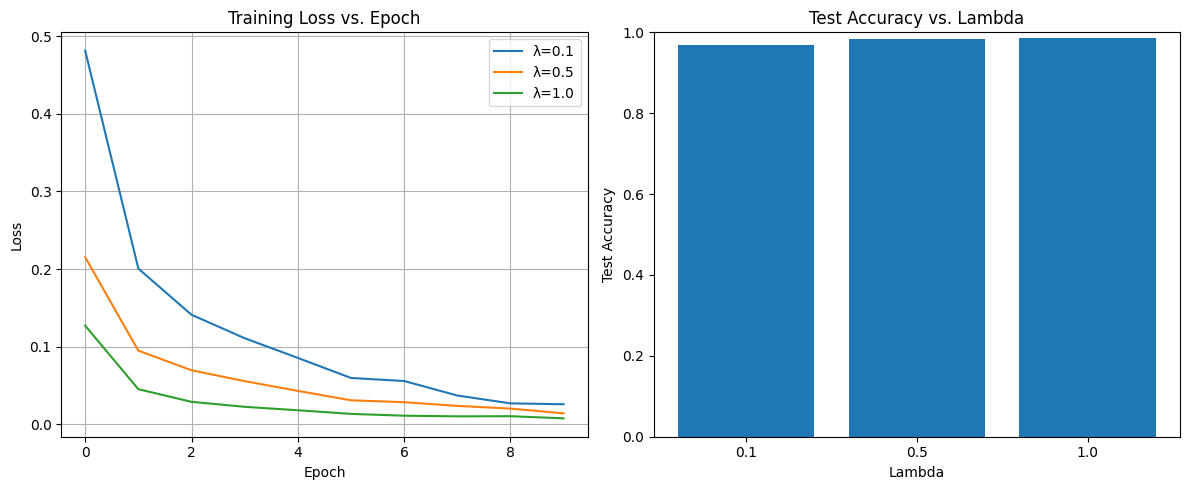

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Loss profiles
plt.subplot(1, 2, 1)
for lambda_val, history in history_dict.items():
    plt.plot(history['loss'], label=f'λ={lambda_val}')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Test accuracies
plt.subplot(1, 2, 2)
plt.bar([str(l) for l in lambda_values], test_accuracies.values())
plt.title('Test Accuracy vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()